![job image](job.jpg "Job image")

# **Project overview**

The goal of this project is to extract required skills from job vacancies and
use them to analyze, cluster, and predict job roles.

The workflow consists of the following main steps:
1. Data preparation and text cleaning
2. Skill extraction using a dictionary-based approach
3. Skill normalization and filtering
4. Exploratory analysis of extracted skills
5. Clustering job vacancies based on skill sets
6. Training a model to predict required skills from vacancy text


In [1]:
# Imports
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.edgecolor": "black",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "0.85",
})

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

# **Dataset imports**

Vacancy dataset imported from Kaggle: https://www.kaggle.com/code/mpwolke/yandex-jobs and translated to english by myself

In [2]:
# Load data
CSV_PATH = "data/yandex vacancies eng.csv"
df = pd.read_csv(CSV_PATH)

df.head()


,Header,Emoji,Description,Requirements,Tasks,Pluses,Hashtags,Link,Raw text
0,Senior Java Developer at Music,🎧,"You'll be working with high-load, large-data p...","• Strong knowledge of Java, DBMS, and Linux\n•...","• design new features, support and develop exi...",• experience developing distributed systems wi...,Senior Java Frontend,https://ya.cc/t/26NhxwD4CH6Ur,Senior Java Developer at Music🎧\n\nYou'll be w...
1,Python developer at Yandex.Lavka,🍔,Yandex.Lavka is a 15-minute grocery delivery s...,• Three years of experience in Python\n• Exper...,• create new features\n• work on product archi...,• experience in designing and developing high-...,python,https://ya.cc/t/XcMZJL3TCH7gZ,Python Developer at Yandex.Lavka 🍔\n\nYandex.L...
2,Front-end developer at Vertical,🏠,The verticals are classifieds services: Avto.r...,• Experience developing with JS and Node.js\n•...,• Develop desktop and mobile interfaces for va...,"• experience with TypeScript, Docker and CI/CD...",React frontend,https://ya.cc/t/P-Ndw5BUCGcUm,Frontend Developer at Vertical 🏠\n\nVerticals ...
3,iOS Developer at Vertical (Bootcamp),🍏,The verticals are classifieds services: Avto.r...,• At least two years of commercial iOS develop...,"• design new application features, support and...",• experience in multithreaded programming and ...,mobile iOS,https://ya.cc/t/9eoluR6OCGcqY,iOS Developer in Verticals (Bootcamp)🍏\n\nVert...
4,Senior Developer in the Serverless Computing D...,👨,Yandex Functions is a serverless computing sys...,• experience developing in C++\n• understand t...,• address issues of isolation of both data and...,• experience with virtualization and container...,CPP,https://ya.cc/t/zFsx4utJCP6MH,Senior Developer in the Serverless Computing D...


Skills dataset in order to expand skill dictionary with more skills. Imported from Kaggle: https://www.kaggle.com/datasets/zamamahmed211/skills and converted into csv

In [3]:
# Dataset full of different skills (May be useful)
import pandas as pd
import re

SKILLS_PATH = "data/skills_dataset.csv"
skills_df = pd.read_csv(SKILLS_PATH)

skills_df.head()

,Skills
0,Python
1,Java
2,JavaScript
3,C++
4,C#


# **Text preparation**

Before extracting skills, all relevant text fields are cleaned and combined
into a single text block per vacancy.

This step ensures that:
- missing values do not break later processing,
- all relevant information is available in one place,
- duplicated text segments are removed.

Combining the text fields allows the skill extraction step to work on a
consistent and complete representation of each job vacancy.


In [4]:
# Basic cleaning

for col in ["Requirements", "Description", "Pluses", "Hashtags"]:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)
    else:
        df[col] = ""

# Combine text fields for skill extraction
# Use set to remove duplicated text blocks

def combine_unique_text(row):
    parts = {
        row["Requirements"].strip().lower(),
        row["Description"].strip().lower(),
        row["Pluses"].strip().lower(),
        row["Hashtags"].strip().lower(),
    }
    parts.discard("")  # remove empty strings
    return "\n".join(parts)

df["text"] = df.apply(combine_unique_text, axis=1)

## Skill extraction

Skills are extracted using a dictionary-based regex approach.
Each skill is mapped to a regular expression that captures common variations
and spelling differences.

This method was chosen because:
- the dataset does not contain labeled entities for training NER models,
- the list of skills should be interpretable and controllable,
- false positives can be manually handled and corrected.

Compared to black-box NLP models, this approach offers full transparency and
is suitable for an applied, exploratory project.

In [5]:
# Key = canonical name, value = regex that matches common variants
skills_regex = {
    # Languages
    "python": r"\bpython\b",
    "java": r"\bjava\b",
    "kotlin": r"\bkotlin\b",
    "swift": r"\bswift\b",
    "go": r"\bgolang\b|\bgo\s+(language|lang|developer|dev)\b",
    "ruby": r"\bruby\b",
    "php": r"\bphp\b",
    "scala": r"\bscala\b",
    "c": r"\bc\b(?!\+|\#)",               # tries to avoid catching c++ / c#
    "c++": r"\bc\+\+\b|\bcpp\b",
    "c#": r"\bc\#\b|c\s*sharp",
    ".net": r"\.net\b|dotnet",
    "javascript": r"\bjavascript\b|\bjs\b",
    "typescript": r"\btypescript\b|\bts\b",

    # Web / frontend
    "html": r"\bhtml\b",
    "css": r"\bcss\b",
    "sass": r"\bsass\b|\bscss\b",
    "react": r"\breact\b",
    "next.js": r"\bnext\.?js\b",
    "vue": r"\bvue\b|\bvue\.?js\b",
    "angular": r"\bangular\b",
    "redux": r"\bredux\b",

    # Backend / frameworks
    "node.js": r"\bnode\.?js\b|\bnodejs\b",
    "express": r"\bexpress\b",
    "nestjs": r"\bnest\.?js\b|\bnestjs\b",
    "spring": r"\bspring\b",
    "spring boot": r"\bspring\s*boot\b",
    "django": r"\bdjango\b",
    "flask": r"\bflask\b",
    "fastapi": r"\bfastapi\b",
    "laravel": r"\blaravel\b",
    "rails": r"\brails\b|ruby on rails",

    # Databases
    "sql": r"\bsql\b",
    "postgresql": r"\bpostgres(?:ql)?\b",
    "mysql": r"\bmysql\b",
    "mongodb": r"\bmongo(?:db)?\b",
    "redis": r"\bredis\b",
    "elasticsearch": r"\belasticsearch\b|\belk\b",

    # DevOps / cloud
    "linux": r"\blinux\b",
    "git": r"\bgit\b",
    "docker": r"\bdocker\b",
    "kubernetes": r"\bkubernetes\b|\bk8s\b",
    "terraform": r"\bterraform\b",
    "ansible": r"\bansible\b",
    "ci/cd": r"\bci\/cd\b|\bcicd\b|\bcontinuous integration\b",
    "aws": r"\baws\b|amazon web services",
    "gcp": r"\bgcp\b|google cloud",
    "azure": r"\bazure\b|microsoft azure",

    # APIs / messaging
    "rest": r"\brest\b|\brestful\b",
    "graphql": r"\bgraphql\b",
    "grpc": r"\bgrpc\b",
    "kafka": r"\bkafka\b",
    "rabbitmq": r"\brabbitmq\b",

    # Data / ML
    "pandas": r"\bpandas\b",
    "numpy": r"\bnumpy\b",
    "scikit-learn": r"scikit[-\s]?learn|\bsklearn\b",
    "pytorch": r"\bpytorch\b",
    "tensorflow": r"\btensorflow\b",
    "spark": r"\bspark\b|\bpyspark\b",
    "airflow": r"\bairflow\b",
}

# IMPORTANT: keep a clean copy of manual dict
skills_regex_manual = dict(skills_regex)

print("Manual skills_regex size:", len(skills_regex_manual))

Manual skills_regex size: 60


## Skill normalization

After raw skill extraction, different variants of the same skill are
normalized into a single canonical form.

For example:
- "node.js", "nodejs", and "node_js" → "nodejs"
- "ci/cd", "ci cd", and "cicd" → "ci_cd"

Normalization reduces noise in the data and ensures that the same skill is not
counted multiple times under different names.
This step is crucial for reliable statistics, clustering, and model training.

In [6]:
# --- Skill normalization: config & helpers ---

SKILL_CANONICAL_MAP = {
    # JS ecosystem
    "node.js": "nodejs",
    "nodejs": "nodejs",
    "node_js": "nodejs",
    "express": "express",
    "expressjs": "express",

    # CI/CD variants
    "ci/cd": "ci_cd",
    "cicd": "ci_cd",
    "ci-cd": "ci_cd",
    "ci cd": "ci_cd",

    # Spark variants
    "pyspark": "spark",
    "apache spark": "spark",
    "spark": "spark",

    # DB variants
    "postgres": "postgresql",
    "postgresql": "postgresql",
    "postgre": "postgresql",

    # ML libs
    "scikit-learn": "sklearn",
    "scikit learn": "sklearn",
    "sklearn": "sklearn",

    # C-family
    "c": "c",
    "c++": "cpp",
    "cpp": "cpp",
    "c#": "csharp",
    "csharp": "csharp",

    # Go
    "golang": "go",
    "go": "go",
    "go lang": "go",

    # Common skills
    "python": "python",
    "java": "java",
    "kotlin": "kotlin",
    "javascript": "javascript",
    "js": "javascript",
    "typescript": "typescript",
    "ts": "typescript",
    "react": "react",
    "reactjs": "react",
    "redux": "redux",
    "html": "html",
    "css": "css",
    "git": "git",
    "linux": "linux",
    "docker": "docker",
    "sql": "sql",
    "mysql": "mysql",
    "tensorflow": "tensorflow",
    "tf": "tensorflow",
    "pytorch": "pytorch",
    "torch": "pytorch",
}

## Handling ambiguous skills

Some skill names, such as "C" or "Go", are ambiguous and may appear in text
without referring to a programming language.

To reduce false positives, additional contextual checks are applied.
A skill is only kept if the surrounding text clearly indicates that it refers
to the programming language and not a general word or abbreviation.

This filtering step improves precision without removing valid skill mentions.

In [7]:
DANGEROUS_CANONICAL = {"c", "go"}

def _valid_dangerous(canonical: str, text: str) -> bool:
    t = (text or "").lower()

    if canonical == "go":
        return ("golang" in t) or ("go lang" in t)

    if canonical == "c":
        return (
            "ansi c" in t
            or "c language" in t
            or "embedded c" in t
            or "iso c" in t
        )

    return True

def normalize_skills(raw_skills: list[str], text: str) -> list[str]:
    norm = []
    for s in raw_skills:
        s0 = str(s).strip().lower()
        canonical = SKILL_CANONICAL_MAP.get(s0, s0)

        if canonical in DANGEROUS_CANONICAL and not _valid_dangerous(canonical, text):
            continue

        norm.append(canonical)

    out = set(norm)

    if ("cpp" in out) or ("csharp" in out):
        out.discard("c")

    return sorted(out)

print("Normalization ready.")

Normalization ready.


## Using an external skills dataset

To extend the initial skill dictionary, an additional skills dataset from
Kaggle is used.
This dataset contains many technical skills that may not be present in the
manually defined list.

The dataset is used to improve coverage of skill extraction.
All skills are cleaned and normalized using the same rules as before and are
only kept if they appear in the vacancy dataset.

This prevents adding irrelevant or very rare skills and keeps the final skill
dictionary focused and usable for further analysis.


In [8]:
# --- Process Kaggle skills dataset ---

raw = (
    skills_df["Skills"]
    .astype(str)
    .str.replace('"', '', regex=False)
    .str.strip()
    .str.lower()
)

raw = raw[raw.notna()]
raw = raw[~raw.isin(["", "nan", "none", "null"])]
raw = raw[raw.str.len() >= 2]

# Noise filtering (non-capturing group to avoid pandas warning)
BAD_PATTERNS = [
    r"[^\x00-\x7F]",  # non-latin
    r"\d",            # digits
    r"\b(?:pay|salary|equity|insurance|travel|student|retention|payback|bullet)\b",
]
bad_re = re.compile("|".join(BAD_PATTERNS))

raw = raw[~raw.str.contains(bad_re, regex=True)]

raw_unique = sorted(set(raw.tolist()))

# Normalize Kaggle skills using normalization
norm_skills = []
for s in raw_unique:
    out = normalize_skills([s], text=s)  # context = itself
    if out:
        norm_skills.extend(out)

norm_unique = sorted(set(norm_skills))

def _safe_regex(skill: str) -> str:
    return rf"(?<!\w){re.escape(skill)}(?!\w)"

# --- FILTER by vacancy dataset frequency (document frequency) ---
MIN_DOC_FREQ = 5  # tune: 3, 5, 10

# compile patterns once for speed
cand_compiled = {s: re.compile(_safe_regex(s), flags=re.IGNORECASE) for s in norm_unique}

doc_freq = {s: 0 for s in norm_unique}
texts = df["text"].astype(str).tolist()

for text in texts:
    for s, pat in cand_compiled.items():
        if pat.search(text):
            doc_freq[s] += 1

kaggle_kept = sorted([s for s, c in doc_freq.items() if c >= MIN_DOC_FREQ])

# RESET to manual dict, then add only kept Kaggle skills
skills_regex = dict(skills_regex_manual)

added = 0
for s in kaggle_kept:
    if s not in skills_regex:
        skills_regex[s] = _safe_regex(s)
        added += 1

print(f"[skills_dataset] Raw unique: {len(raw_unique)}")
print(f"[skills_dataset] Normalized unique: {len(norm_unique)}")
print(f"[skills_dataset] Kept by df >= {MIN_DOC_FREQ}: {len(kaggle_kept)}")
print(f"[skills_dataset] Added to skills_regex: {added}")
print(f"[skills_dataset] Final skills_regex size: {len(skills_regex)}")


[skills_dataset] Raw unique: 2412
[skills_dataset] Normalized unique: 2410
[skills_dataset] Kept by df >= 5: 67
[skills_dataset] Added to skills_regex: 40
[skills_dataset] Final skills_regex size: 100


In [9]:
# Skill extraction (regex)
def extract_skills(text: str) -> list[str]:
    found = []
    for skill, pattern in skills_regex.items():
        if re.search(pattern, text, flags=re.IGNORECASE):
            found.append(skill)
    return found

# 1) raw extraction
df["skills_raw"] = df["text"].apply(extract_skills)

# 2) canonical normalization + dedup per vacancy
df["skills"] = df.apply(lambda r: normalize_skills(r["skills_raw"], r["text"]), axis=1)

df["skills_count"] = df["skills"].apply(len)

df[["skills", "skills_count"]].head()

,skills,skills_count
0,"[java, linux, mongodb, processing]",4
1,"[git, python]",2
2,"[ci_cd, docker, javascript, nodejs, react, red...",7
3,"[objective-c, swift]",2
4,"[cpp, processing, virtualization]",3


# **Plots and analysis of extracted skills**
The goal of this exploratory analysis is to understand how extracted skills
are distributed across job vacancies.
This helps to evaluate whether the extraction approach is reasonable and to
decide if additional filtering or normalization steps are needed.

In [10]:
# Plot helpers
def plot_hist(series, title, xlabel, ylabel, bins=30):
    plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_bar(series, title, xlabel, ylabel="Count"):
    counts = series.value_counts().sort_index()

    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

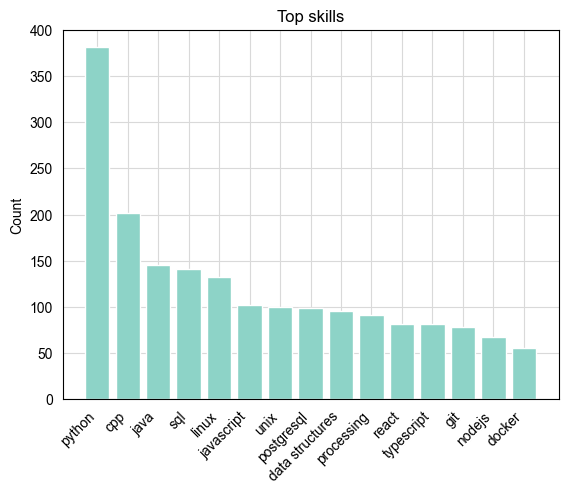

In [11]:
# Skill frequency
all_skills = [s for row in df["skills"] for s in row]
skill_freq = Counter(all_skills)

top = skill_freq.most_common(15)
labels = [k for k, _ in top]
values = [v for _, v in top]

plt.figure()
plt.bar(labels, values)
plt.xticks(rotation=45, ha="right")
plt.title("Top skills")
plt.ylabel("Count")
plt.show()


Some skills, such as Python and SQL, appear much more often than others.
This shows that the dataset is dominated by a small number of very common
skills.

This behavior is expected, as these skills are required across many
different job roles.

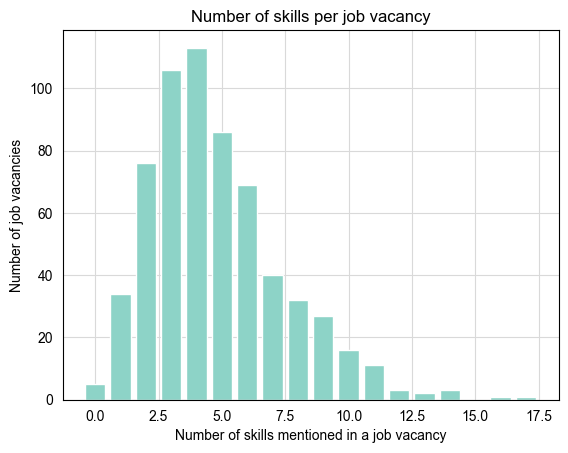

In [12]:
# Skills per job
plot_bar(
    df["skills_count"],
    title="Number of skills per job vacancy",
    xlabel="Number of skills mentioned in a job vacancy",
    ylabel="Number of job vacancies"
)


# for example 150 vacancies require 2 skills, 60 vacancies require 4 skills, etc.

This plot shows how many skills are mentioned in each job vacancy.
Most vacancies list only a small number of skills, while only a few
vacancies mention many skills.

This indicates that job descriptions are usually focused on a specific role
and do not contain long or exhaustive skill lists.


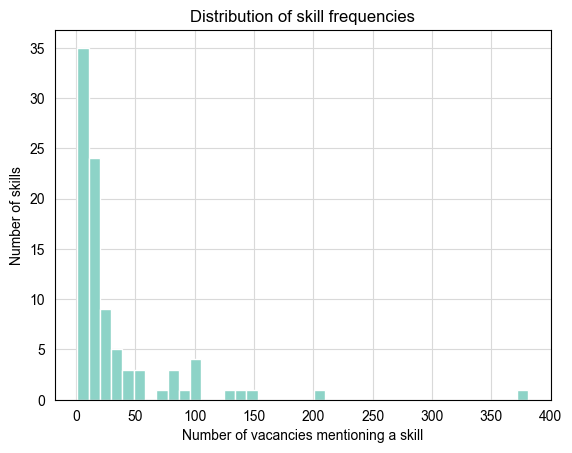

In [13]:
from collections import Counter

all_skills = [s for skills in df["skills"] for s in skills]
skill_freq = Counter(all_skills)

skill_freq_series = pd.Series(skill_freq.values())

plot_hist(
    series=skill_freq_series,
    title="Distribution of skill frequencies",
    xlabel="Number of vacancies mentioning a skill",
    ylabel="Number of skills",
    bins=40
)

# for example 25 skills are mentioned in ~7 vacancies, 1 skill is mentioned in ~280 vacancies, etc
# for example sql or python are mentioned in ~280 vacancies, while some rare skills (around 28 of them) are mentioned in only several vacancies

The distribution shows that most skills are mentioned in only a small number
of vacancies, while a few skills occur very frequently.

This long-tail pattern is typical for job market data, where common
technologies appear everywhere and specialized skills are required only in
specific roles.


## **Conclusion of skill analysis**

Overall, the exploratory analysis shows a clear imbalance in skill
frequencies.
A small number of skills (such as Python or SQL) appear in many vacancies,
while most skills are relatively rare.

Most job vacancies mention only a few skills, which suggests that job
descriptions are concise and role-specific.
This confirms that a dictionary-based skill extraction approach is suitable
for this dataset.

The observed imbalance also motivates later steps such as skill
normalization and frequency-based filtering, in order to reduce noise and
improve the quality of clustering and classification.

## Skill frequency filtering

To reduce noise and improve model stability, skills are filtered based on how
often they appear across vacancies.

Very rare skills are removed because they:
- provide little statistical value,
- increase sparsity,
- make clustering and classification harder.

Very common skills are also limited to avoid dominance.
The remaining skills form a balanced feature set for later analysis.

A minimum document frequency threshold is applied to remove very rare skills.
In this project, a value of 5 was chosen to keep useful but less frequent
skills, while still reducing sparsity and noise in the data.

In [14]:
# Filter skills by document frequency
N = len(df)
skill_doc_freq = Counter()

for row in df["skills"]:
    for s in set(row):
        skill_doc_freq[s] += 1

min_df = 5 # previously was max(2, int(0.01 * N)); set to 5 because skipped a lot of useful skills
max_df = int(0.7 * N)

kept_skills = [
    s for s, c in skill_doc_freq.items()
    if min_df <= c <= max_df
]

kept_skills


['java',
 'mongodb',
 'processing',
 'linux',
 'git',
 'python',
 'react',
 'javascript',
 'nodejs',
 'docker',
 'redux',
 'typescript',
 'ci_cd',
 'objective-c',
 'swift',
 'virtualization',
 'cpp',
 'mysql',
 'ansible',
 'postgresql',
 'tcp/ip',
 'devops',
 'microservices',
 'django',
 'flask',
 'rest',
 'spring',
 'data structures',
 'graphql',
 'kotlin',
 'unix',
 'html',
 'css',
 'sql',
 'recommender systems',
 'design patterns',
 'data analysis',
 'spark',
 'tableau',
 'hadoop',
 'teamcity',
 'neural networks',
 'machine learning',
 'backend development',
 'redis',
 'big data',
 'networking',
 'oracle',
 'tensorflow',
 'bash',
 'nosql databases',
 'collaboration',
 'computer vision',
 'kafka',
 'a/b testing',
 'deep learning',
 'pytorch',
 'express',
 'code review',
 'decision-making',
 'airflow',
 'rabbitmq',
 'nlp',
 'control systems',
 'macos',
 'pandas',
 'spring boot',
 'blogging',
 'communication',
 'terraform',
 'aws',
 'azure',
 'kubernetes',
 'vue',
 'angular',
 'csharp'

In [15]:
kept_skills = sorted(kept_skills)

def filter_skills(skills):
    return [s for s in skills if s in kept_skills]

df["skills_filtered"] = df["skills"].apply(filter_skills)

mlb = MultiLabelBinarizer(classes=kept_skills)
X = mlb.fit_transform(df["skills_filtered"])

print("X shape:", X.shape)


X shape: (625, 83)


After filtering the skill set, the remaining skills form a cleaner and more
stable representation of job vacancies.
This representation is used to analyze how skills co-occur within the same
vacancies.

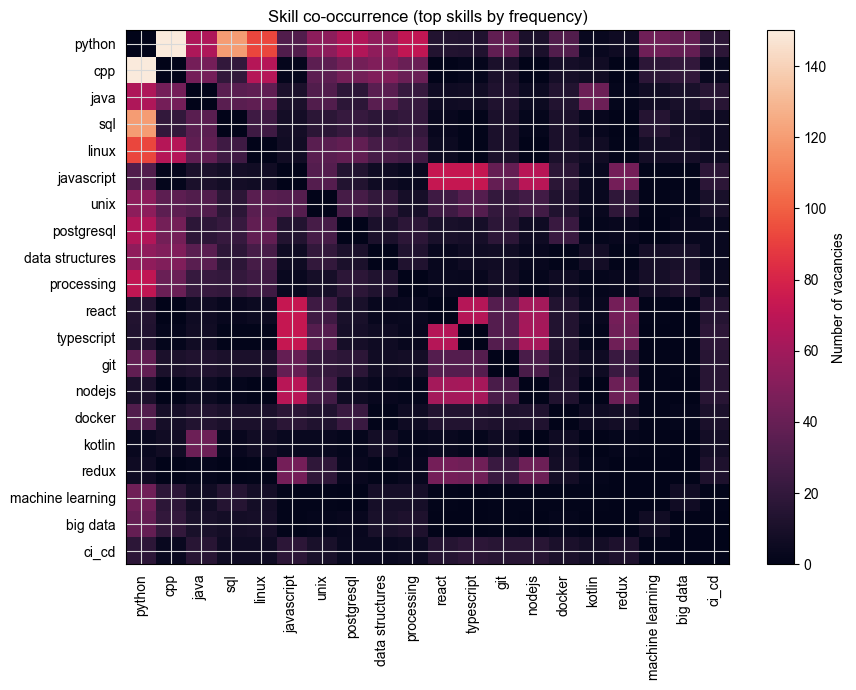

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# compute co-occurrence matrix
co = (X.T @ X).astype(int)
np.fill_diagonal(co, 0)

# choose top skills by frequency
skill_freq = Counter()

for row in df["skills_filtered"]:
    for s in row:
        skill_freq[s] += 1

TOP_N = 20
top_skills = [s for s, _ in skill_freq.most_common(TOP_N)]

# indices of these skills in kept_skills / X
idx = [kept_skills.index(s) for s in top_skills]

co_top = co[np.ix_(idx, idx)]

# plot
plt.figure(figsize=(9, 7))
plt.imshow(co_top, aspect="auto")
plt.xticks(range(len(top_skills)), top_skills, rotation=90)
plt.yticks(range(len(top_skills)), top_skills)
plt.title("Skill co-occurrence (top skills by frequency)")
plt.colorbar(label="Number of vacancies")
plt.tight_layout()
plt.show()

**Interpretation of skill co-occurrence**

The co-occurrence heatmap shows which skills frequently appear together in
job vacancies.
Strong co-occurrence patterns reflect typical technology stacks, such as
backend, frontend, or data-oriented roles.

These relationships justify clustering vacancies based on skill vectors,
as jobs with similar skill combinations naturally form groups.


# **Clustering job vacancies**

Job vacancies are clustered based on their extracted skill sets using HDBSCAN.
Each vacancy is represented as a binary skill vector.

HDBSCAN was chosen because:
- the number of clusters is unknown in advance,
- job roles naturally form dense groups with varying sizes,
- noisy or unclear vacancies can be assigned to a noise cluster.

This allows meaningful job role groups to emerge from the data without forcing
every vacancy into a cluster.

In [17]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,      # role minimal size
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom"
)

labels = clusterer.fit_predict(X)

df["cluster"] = labels


In [18]:
df["cluster"].value_counts().sort_index()

cluster
-1    439
 0     39
 1     38
 2     43
 3     52
 4     14
Name: count, dtype: int64

In [19]:
from collections import Counter

cluster_skills = []

for cl in sorted(df["cluster"].unique()):
    if cl == -1:
        continue

    subset = df[df["cluster"] == cl]
    freq = Counter([s for row in subset["skills_filtered"] for s in row])

    cluster_skills.append({
        "cluster": cl,
        "size": len(subset),
        "top_skills": ", ".join([s for s, _ in freq.most_common(10)])
    })

pd.DataFrame(cluster_skills).sort_values("size", ascending=False)

,cluster,size,top_skills
3,3,52,"cpp, python, data structures, linux, processin..."
2,2,43,"python, linux, java, unix, big data, processin..."
0,0,39,"sql, python, processing, tableau, big data, li..."
1,1,38,"java, kotlin, swift, ci_cd, objective-c, git, ..."
4,4,14,"cpp, linux, data structures, computer vision"


The presence of a noise cluster is expected, as not all vacancies clearly
match a single dominant skill pattern.


## Cluster interpretation

Each cluster is characterized by a set of frequently co-occurring skills.
These skill combinations correspond to typical job roles such as backend,
data, or systems-oriented positions.

Vacancies labeled as noise do not strongly match any dominant skill pattern
and likely represent hybrid or uncommon roles.
Overall, the clustering results show that job roles can be identified using
skill-based representations.


In [20]:
df[df["cluster"] == 0][["Header", "skills"]].head(5)

,Header,skills
60,Product Analyst at Search,"[python, sql]"
75,Warehouse Logistics Analyst at Market,"[processing, python, sql]"
76,Regional Analyst at Market,"[python, sql]"
80,Analyst at Rover,"[big data, python, sql]"
119,Analyst at Search,"[python, sql]"


Using HDBSCAN, similar job vacancies were grouped into clusters based on shared skills. The clusters represent common job roles such as frontend, backend, data, and DevOps, while less clear vacancies were labeled as noise. Overall, the results show that job roles can be identified using skill-based representations.

While clustering groups similar job roles, a classification model is used to
predict required skills directly from vacancy text for new or unseen cases.


# **Skill prediction model**

In addition to clustering, a multi-label classification model is trained to
predict required skills directly from vacancy text.

The model uses:
- TF-IDF features extracted from job descriptions,
- a One-vs-Rest logistic regression classifier,
- multi-label output to allow prediction of multiple skills per vacancy.

This model enables skill prediction for new or unseen job descriptions.

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, hamming_loss
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

df_train = df[df["skills_filtered"].apply(len) > 0].copy()

X_text = df_train["text"].fillna("").astype(str)
y_lists = df_train["skills_filtered"]

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y_lists)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_text, Y, test_size=0.2, random_state=42
)

custom_stop = set(ENGLISH_STOP_WORDS)
custom_stop.discard("go")   # keep "go" token
custom_stop = list(custom_stop)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 3),     # was (1, 2)
        min_df=2,
        max_df=0.9,
        sublinear_tf=True,
        max_features=250_000,
        stop_words=custom_stop   # reduce noise in vacancy text
    )),
    ("ovr", OneVsRestClassifier(
        LogisticRegression(
            solver="liblinear",
            max_iter=3000,
            class_weight="balanced"
        )
    ))
])

clf.fit(X_train, Y_train)

Y_val_proba = clf.predict_proba(X_val)
Y_val_pred = (Y_val_proba >= 0.5).astype(int)

micro_f1 = f1_score(Y_val, Y_val_pred, average="micro", zero_division=0)
macro_f1 = f1_score(Y_val, Y_val_pred, average="macro", zero_division=0)
weighted_f1 = f1_score(Y_val, Y_val_pred, average="weighted", zero_division=0)
hamming = hamming_loss(Y_val, Y_val_pred)

def predict_skills(text: str, top_k: int = 10, return_proba: bool = False):
    p = clf.predict_proba([str(text)])[0]
    idx = np.argsort(p)[::-1][:top_k]

    if return_proba:
        return [(mlb.classes_[i], float(p[i])) for i in idx]
    return [mlb.classes_[i] for i in idx]


In [22]:
print(f"Micro F1:          {micro_f1:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")
print(f"Weighted F1:       {weighted_f1:.4f}")
print(f"Hamming loss:      {hamming:.4f}")

Micro F1:          0.8146
Macro F1:          0.5537
Weighted F1:       0.7838
Hamming loss:      0.0202


## **Model evaluation**

The Micro F1 score is relatively high, indicating good performance on common
skills.
The lower Macro F1 score shows that rare skills are harder to predict, which
is expected given the imbalanced skill distribution.

The low Hamming loss indicates that the model makes few label-level mistakes.
Overall, the model performs well for predicting typical skill requirements
from job descriptions.

# Lets check the model in action

In [23]:
predict_skills("software engineer", top_k=10)

['python',
 'cpp',
 'java',
 'linux',
 'sql',
 'postgresql',
 'javascript',
 'git',
 'docker',
 'unix']

The trained model can predict relevant skills for new job descriptions by analyzing the text and outputting the most probable skills based on learned patterns from the training data.

In [24]:
vocab = clf.named_steps["tfidf"].vocabulary_
print("go" in vocab)

True


In [25]:
go_count = sum(s == "go" for row in y_lists for s in row)
print("go label frequency:", go_count)

go label frequency: 12


# **Conclusion**

This project demonstrates that job vacancies can be transformed into
structured skill representations and analyzed using machine learning.

The combination of rule-based skill extraction, clustering, and classification
provides interpretable insights into job roles and required competencies.
While rare skills remain challenging, the results are suitable for exploratory
analysis and practical applications such as career guidance or job matching.
